In [1]:
###library 
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, make_scorer, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline 
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import re
import numpy as np
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from tqdm import tqdm
import matplotlib.pyplot as plt

##### Load Data

In [ ]:
df = pd.read_excel(r"D:\TA\olx\nama produk final TA.xlsx", sheet_name='skenario 1')
encoder = LabelEncoder()
df['kategori_encoding'] = encoder.fit_transform(df['Kategori'])

In [3]:
kategori = {kategori: index for index, kategori in enumerate(encoder.classes_)}
kategori

{'Elektronik & Gadget': 0,
 'Hobi & Olahraga': 1,
 'Kantor & Industri': 2,
 'Keperluan Pribadi': 3,
 'Mobil': 4,
 'Motor': 5,
 'Perlengkapan Bayi & Anak': 6,
 'Properti': 7,
 'Rumah Tangga': 8}

In [4]:
print(df.shape)
print(df['Kategori'].value_counts())

(51218, 6)
Kategori
Elektronik & Gadget         13793
Properti                     9954
Keperluan Pribadi            5906
Hobi & Olahraga              5369
Mobil                        4588
Rumah Tangga                 4185
Motor                        3162
Kantor & Industri            2779
Perlengkapan Bayi & Anak     1482
Name: count, dtype: int64


##### Praproses

In [ ]:
# CASE FOLDING DAN CLEANING 
def preprocess_text(text):
    text = text.lower()  #lowercase
    text = re.sub('[^a-zA-Z ]', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

df['Nama Produk Clean'] = df['Nama Produk'].apply(preprocess_text)

In [ ]:
#  STEMMING
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text):
    return stemmer.stem(text)

# memantau progress
tqdm.pandas(desc="Proses Stemming")
df['Nama Produk Stemming'] = df['Nama Produk Clean'].progress_apply(stem_text)


In [ ]:
# daftar stopwords
stop_words = set(stopwords.words('indonesian'))

# untuk menghapus stopwords dari teks
def remove_stopwords(text):
    words = text.split()  #tokenize
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df['Nama Produk Final'] = df['Nama Produk Stemming'].apply(remove_stopwords)

In [4]:
# custom words
kata_dihapus  = [
    'ab', 'aal', 'aan', 'aau', 'abab', 'abang', 'abaya', 'abb', 'abc', 'abd', 'abdullah',  'abis', 'abiss', 'acacia', 'aceh', 'ach', 'adacom', 'add', 'adh', 'adi', 'adik',  'adis', 'ado', 'adzan', 'agak', 'agh', 'agm', 'aha', 'aja', 'ajah', 'aji', 'akan', 'akd', 'akj', 'aky', 'alai', 'alamsyah', 'alcott', 'ald', 'all', 'allah',  'almost', 'almuslim', 'aman', 'amanah', 'ambil', 'amed', 'amel', 
    'amin', 'amma', 'ammar', 'amn', 'and', 'anda', 'angels', 'angsu', 'annis', 'ansari', 'ansi', 'antasa', 'anugerah', 'anugrah', 'apalagi', 'apik', 'apk',  'aqa', 'arti', 'asli', 'asy', 'atau', 'att', 'auladi', 'awet', 'ayah', 'baru',
    'ayahanda', 'baba', 'babal', 'babar', 'babarsari', 'bad', 'bae', 'bagas', 'bagus', 'baik', 'bambang', 'bandarlampung', 'banged', 'bangeet', 'banget',  'bangets', 'bangetttt', 'banguntapan', 'bangus', 'banten', 'banyak', 
    'bareng', 'batam', 'bebi', 'bekas', 'beli', 'belum', 'bener', 'berapa', 'bersih', 'besar', 'bestie', 'betul', 'biar', 'biasa', 'bik', 'bikin', 
    'binjai', 'bisa', 'bismillah', 'bismillahirrahmanirrahim', 'bkp', 'blc', 'blkg', 'blkng', 'bontot', 'borong', 'brandnew', 'budi', 'buruk', 'dan', 'canggih', 
    'cantik', 'cell', 'cerdas', 'cicil', 'cod', 'cuma', 'dapat', 'dari', 'dekat', 'dibersihin', 'diskon', 'dpn', 'dulu', 'gampang', 'ganti', 'gembira', 'gratis', 
    'gruduk', 'halim', 'handal', 'hanya', 'hari', 'harum', 'ideal', 'ilmin', 'ingin', 'istimewa', 'izin', 'jangan', 'jawi', 'jelek', 'jemput', 'jual', 'kecil', 'keren', 'kalo', 'kotabaru', 'kreatif', 'krna', 'kuat', 'latin', 'lengkap', 
    'lewat', 'luas', 'mahal', 'makmur', 'mana', 'mandala', 'mansyur', 'mantap', 'mapan', 'masih', 'maupun', 'mdn', 'medang', 'mewah', 'minta', 
    'modern', 'mudah', 'mulus', 'murah', 'nego', 'ngk', 'nyaman', 'ori', 'orisinil', 'orlglnal', 'pahoman', 'palemban', 'palembang', 'palembangstar', 'paling', 'panbil', 'panjang', 'pas', 'pendek', 'petisah', 
    'pinggir', 'plong', 'pragmatic', 'preloved', 'promo', 'puas', 'ramah', 'ramai', 'original', 'ready', 'resmi', 'riau', 'ribet', 'saja', 'salah', 'sampai', 
    'sangat', 'santuy', 'second', 'sederhana', 'segar', 'sejahtera', 'sekarang','selesai', 'sempurna', 'semua', 'senang', 'sepakat', 'siap', 'sidoarjo', 'simpang', 'spesial', 'strategis', 'sudah', 'sukajadi', 'sukses', 'taa', 'tapi', 'tdk', 'tebal', 'telah', 'telukbetung', 'tenang', 'tentram', 'terjangkau', 'tipis', 'tunggu', 'unik', 'unila', 'wahidin', 'wajib', 'yang'
]  

for kata in kata_dihapus:
    df['Nama Produk Final'] = df['Nama Produk Final'].str.replace(r'\b' + kata + r'\b', '', regex=True)

# menghapus kata yang terdiri dari satu huruf atau karakter yang berulang
df['Nama Produk Final'] = df['Nama Produk Final'].str.replace(r'\b(\w)\1+\b', '', regex=True)  
df['Nama Produk Final'] = df['Nama Produk Final'].str.replace(r'\b\w\b', '', regex=True)  

In [ ]:
# kata yang ingin dicari
kata = 'sewa'

# jumlah kemunculan kata 
jumlah = df['Nama Produk Final'].str.count(r'\b' + kata + r'\b').sum()

print(f"Kata : '{kata}'")
print(f"Jumlah = {jumlah}")


Kata : 'sewa'
Jumlah = 2276


#### **split**


In [5]:
# split data
X_train, X_test, y_train, y_test = train_test_split(df['Nama Produk Final'], df['kategori_encoding'], 
                                                    stratify= df['kategori_encoding'], test_size=0.2, random_state=42)

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (40974,)
Shape of X_test: (10244,)
Shape of y_train: (40974,)
Shape of y_test: (10244,)


In [10]:
original_counts = df['kategori_encoding'].value_counts().sort_index()
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

original_proportions = original_counts / original_counts.sum()
train_proportions = train_counts / train_counts.sum()
test_proportions = test_counts / test_counts.sum()

distribution_df = pd.DataFrame({
    'kategori encode': original_counts.index,
    'Jumlah Data Original': original_counts.values,
    'Jumlah Data Latih': train_counts.values,
    'Jumlah Data Uji': test_counts.values,
})
print(distribution_df)

   kategori encode  Jumlah Data Original  Jumlah Data Latih  Jumlah Data Uji
0                0                 13793              11034             2759
1                1                  5369               4295             1074
2                2                  2779               2223              556
3                3                  5906               4725             1181
4                4                  4588               3670              918
5                5                  3162               2530              632
6                6                  1482               1186              296
7                7                  9954               7963             1991
8                8                  4185               3348              837


#### **modelling**

In [6]:
pipeline_1 = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True)),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(metric='cosine'))
])

param_grid_1 = {
    'knn__n_neighbors': range(1, 21),
    'knn__weights': ['uniform', 'distance'] 
}

In [7]:
kf_1 = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search_1 = GridSearchCV(pipeline_1, param_grid_1, cv=kf_1, scoring='accuracy', n_jobs=1,  verbose=2, error_score='raise')
grid_search_1.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time= 1.6min
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=  31.0s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=  29.2s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=  45.0s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=  30.0s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=  26.0s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=  30.2s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=  28.0s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=  26.2s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=  26.6s
[CV] END ...........knn__n_neighbors=2, knn__weights=uniform; total time=  26.0s
[CV] END ...........knn__n_neighbors=2, knn__we

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        sublinear_tf=True)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('knn',
                                        KNeighborsClassifier(metric='cosine'))]),
             n_jobs=1,
             param_grid={'knn__n_neighbors': range(1, 21),
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=2)

In [8]:
best_params_1 = grid_search_1.best_params_
print(f"Best parameters: {best_params_1}")

Best parameters: {'knn__n_neighbors': 4, 'knn__weights': 'distance'}


In [9]:
mean_cv_scores = grid_search_1.cv_results_['mean_test_score']
params = grid_search_1.cv_results_['params']
for param, score in zip(params, mean_cv_scores):
    print(f"{param}: {score:.4f}")

{'knn__n_neighbors': 1, 'knn__weights': 'uniform'}: 0.9123
{'knn__n_neighbors': 1, 'knn__weights': 'distance'}: 0.9123
{'knn__n_neighbors': 2, 'knn__weights': 'uniform'}: 0.9106
{'knn__n_neighbors': 2, 'knn__weights': 'distance'}: 0.9126
{'knn__n_neighbors': 3, 'knn__weights': 'uniform'}: 0.9074
{'knn__n_neighbors': 3, 'knn__weights': 'distance'}: 0.9123
{'knn__n_neighbors': 4, 'knn__weights': 'uniform'}: 0.9076
{'knn__n_neighbors': 4, 'knn__weights': 'distance'}: 0.9128
{'knn__n_neighbors': 5, 'knn__weights': 'uniform'}: 0.9033
{'knn__n_neighbors': 5, 'knn__weights': 'distance'}: 0.9111
{'knn__n_neighbors': 6, 'knn__weights': 'uniform'}: 0.9041
{'knn__n_neighbors': 6, 'knn__weights': 'distance'}: 0.9121
{'knn__n_neighbors': 7, 'knn__weights': 'uniform'}: 0.9007
{'knn__n_neighbors': 7, 'knn__weights': 'distance'}: 0.9105
{'knn__n_neighbors': 8, 'knn__weights': 'uniform'}: 0.9003
{'knn__n_neighbors': 8, 'knn__weights': 'distance'}: 0.9106
{'knn__n_neighbors': 9, 'knn__weights': 'uniform

In [ ]:
cv_score = grid_search_1.best_score_
test_score = grid_search_1.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.9128226981363916
Test score: 0.922491214369387


In [ ]:
print("\nEvaluasi Keseluruhan Data:")
y_test_pred_1 = grid_search_1.predict(X_test)
conf_matrix_test_1 = confusion_matrix(y_test, y_test_pred_1)
class_report_test_1 = classification_report(y_test, y_test_pred_1)
print("Classification Report (Test Data):\n", class_report_test_1)


Evaluasi Keseluruhan Data:
Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      2759
           1       0.91      0.92      0.92      1074
           2       0.78      0.82      0.80       556
           3       0.88      0.89      0.89      1181
           4       0.94      0.95      0.94       918
           5       0.89      0.93      0.91       632
           6       0.83      0.82      0.82       296
           7       0.98      0.98      0.98      1991
           8       0.85      0.87      0.86       837

    accuracy                           0.92     10244
   macro avg       0.89      0.90      0.90     10244
weighted avg       0.92      0.92      0.92     10244



In [88]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_test_pred_1)
print("Akurasi: {:.4f}".format(accuracy))

Akurasi: 0.9225


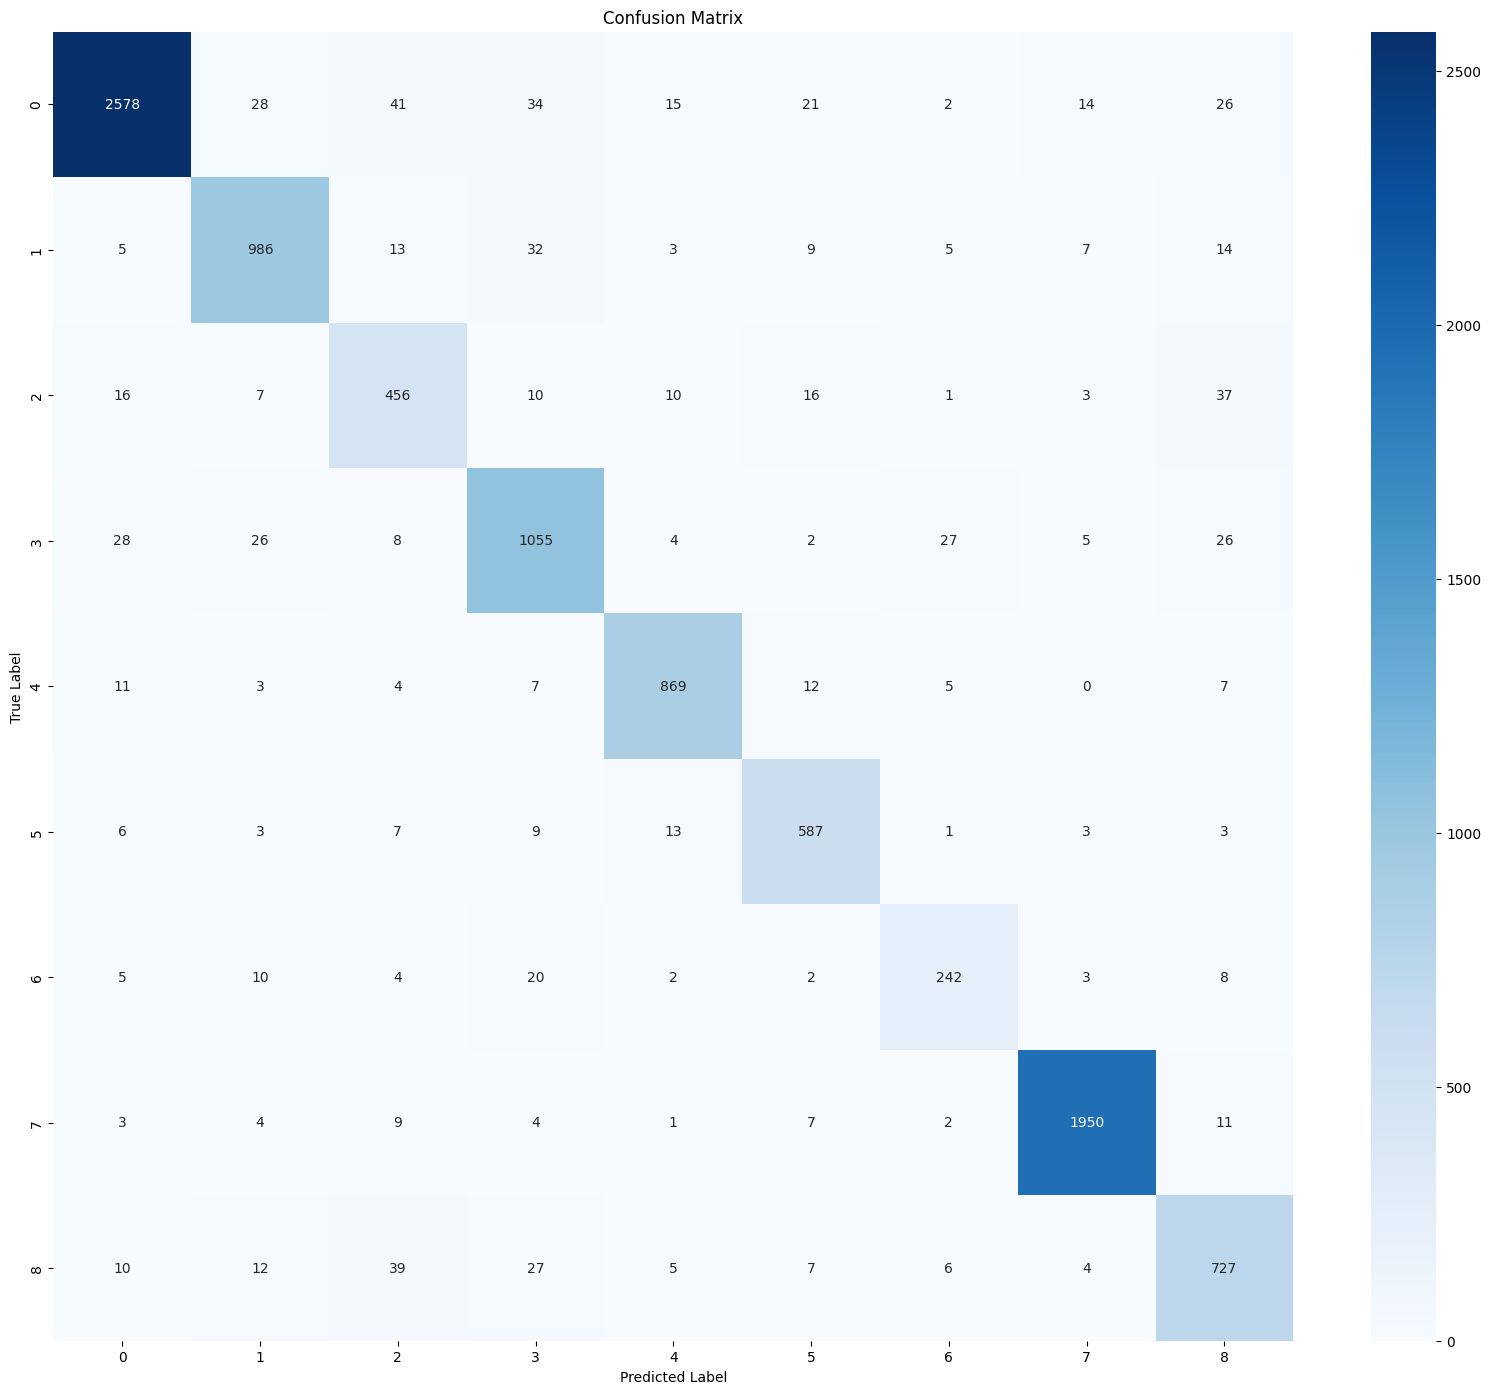

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(20, 17))

sns.heatmap(conf_matrix_test_1, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
actual_class = 46
predicted_class = actual_class - 1  # Karena indeks mulai dari 0

false_positive_indices = np.where((y_test != actual_class) & (y_test_pred_1 == actual_class))[0]
print(f"Jumlah data yang salah diprediksi sebagai kelas {actual_class}: {len(false_positive_indices)}")

false_positive_data = X_test.iloc[false_positive_indices]

false_positive_data['predicted_label'] = y_test_pred_1[false_positive_indices]

print("False Positive Data and their Predicted Labels:")
print(false_positive_data[['predicted_label']].to_string())

# Menyesuaikan opsi tampilan untuk memastikan semua data ditampilkan
pd.set_option('display.max_rows', None)  # Menampilkan semua baris
pd.set_option('display.max_columns', None)  # Menampilkan semua kolom
pd.set_option('display.width', 1000)  # Menambahkan lebar tampilan untuk mencegah pemotongan teks
print(false_positive_data)

Jumlah data yang salah diprediksi sebagai kelas 46: 128
False Positive Data and their Predicted Labels:
predicted_label    [46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 4...
9367                                      gudang  pakai jalan medan 
14343                sewa rumah  tengah kota jalan macan kumbang ixa
15418               rumah oceanic bliss cluster  pasir putih  center
10993                      gudang hook rezeki graha mas sungai panas
10630                                    ruko  jalan  senget jambi  
10458                        ruko gandeng  jalan   sekolah pekanbaru
10430                              sewa bangun usaha dongan jimbaran
10153               ruko komplek algoritma zuri express jalan let...
47790                                tanah jalan medan  rina ginting
9580                         ruko jalan krakatau ujung ricky antonio
26922                 ruko kost lantai fully furnished nagoya square
15249                       sewa rumah cahaya garden tahap sei panas

In [ ]:

# Buat DataFrame untuk false negatives
false_positive_data = pd.DataFrame({
    'predicted_label': y_test_pred_1[false_positive_indices],
    'features': X_test.iloc[false_positive_indices].values.tolist() 
})

false_positive_data.to_csv('false_positive_data.csv', index=False)
print("Data telah disimpan ke 'false_positive_data.csv'")


Data telah disimpan ke 'false_positive_data.csv'


In [ ]:
def prediksi_interaktif(pipeline, encoder):
    while True:
        produk = input("Masukkan nama produk (atau ketik 'exit' untuk keluar): ")
        if produk.lower() == 'exit':
            break
        prediksi = pipeline.predict([produk])
        kategori = encoder.inverse_transform(prediksi)
        print(f"Kategori prediksi untuk '{produk}' adalah: {kategori[0]}")
prediksi_interaktif(grid_search_1, encoder) 

### insight ###

In [ ]:
tfidf_filtered = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2), )

tfidf_matrix_filtered = tfidf_filtered.fit_transform(df['Nama Produk Final'])

df_df_filtered = pd.DataFrame({
    'Term': tfidf_filtered.get_feature_names_out(),
    'Document Frequency (DF)': (tfidf_matrix_filtered > 0).sum(axis=0).tolist()[0]
})
print(df_df_filtered)

                 Term  Document Frequency (DF)
0               abadi                       12
1       abadi cluster                        1
2        abadi dengan                        1
3         abadi harga                        1
4        abadi lokasi                        1
...               ...                      ...
113158      zyo large                        1
113159     zyo medium                        1
113160          zyrex                        1
113161      zyrex sky                        1
113162            zzn                        1

[113163 rows x 2 columns]


In [ ]:
kategori_mapping = dict(zip(df['kategori_encoding'], df['Kategori']))

# kalku distribusi
original_counts = df['kategori_encoding'].value_counts().sort_index()
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

#proporsi
original_proportions = original_counts / original_counts.sum()
train_proportions = train_counts / train_counts.sum()
test_proportions = test_counts / test_counts.sum()

distribution_df = pd.DataFrame({
    'kategori encode': original_counts.index,
    'Kategori Asli': [kategori_mapping[k] for k in original_counts.index],  # Menambahkan kategori asli
    'Jumlah Data Original': original_counts.values,
    'Proporsi Data Original': original_proportions.values,
    'Jumlah Data Latih': train_counts.values,
    'Proporsi Data Latih': train_proportions.values,
    'Jumlah Data Uji': test_counts.values,
    'Proporsi Data Uji': test_proportions.values,
})

# total row
distribution_df.loc['Total'] = distribution_df.sum(numeric_only=True)
distribution_df.at['Total', 'kategori encode'] = 'Total'
distribution_df.at['Total', 'Kategori Asli'] = 'Total'
distribution_df.at['Total', 'Proporsi Data Original'] = distribution_df['Proporsi Data Original'].sum()
distribution_df.at['Total', 'Proporsi Data Latih'] = distribution_df['Proporsi Data Latih'].sum()
distribution_df.at['Total', 'Proporsi Data Uji'] = distribution_df['Proporsi Data Uji'].sum()
distribution_df

,kategori encode,Kategori Asli,Jumlah Data Original,Proporsi Data Original,Jumlah Data Latih,Proporsi Data Latih,Jumlah Data Uji,Proporsi Data Uji
0,0.0,Elektronik & Gadget,13793.0,0.269300,11034.0,0.269293,2759.0,0.269328
1,1.0,Hobi & Olahraga,5369.0,0.104826,4295.0,0.104823,1074.0,0.104842
2,2.0,Kantor & Industri,2779.0,0.054258,2223.0,0.054254,556.0,0.054276
3,3.0,Keperluan Pribadi,5906.0,0.115311,4725.0,0.115317,1181.0,0.115287
4,4.0,Mobil,4588.0,0.089578,3670.0,0.089569,918.0,0.089613
5,5.0,Motor,3162.0,0.061736,2530.0,0.061746,632.0,0.061695
6,6.0,Perlengkapan Bayi & Anak,1482.0,0.028935,1186.0,0.028945,296.0,0.028895
7,7.0,Properti,9954.0,0.194346,7963.0,0.194343,1991.0,0.194358
8,8.0,Rumah Tangga,4185.0,0.081710,3348.0,0.081710,837.0,0.081706
Total,Total,Total,51218.0,2.000000,40974.0,2.000000,10244.0,2.000000


In [ ]:

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Nama Produk Final'])
#convert ke matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


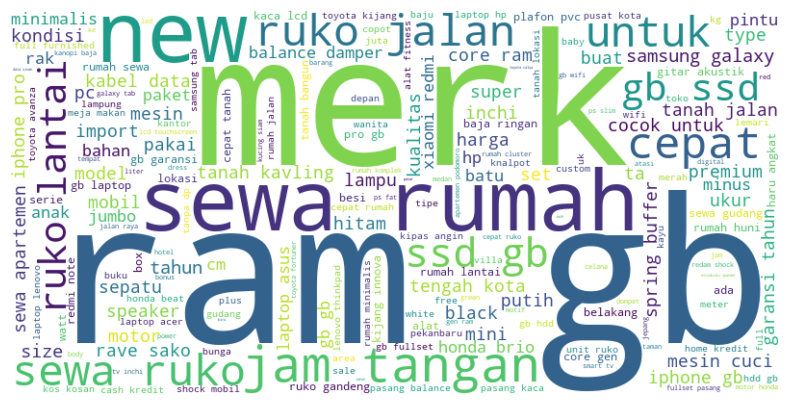

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join(df['Nama Produk Final']) #all produk


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

C:\Users\Naomi Natasya\AppData\Local\Temp\ipykernel_3112\2533024361.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=distribusi_kategori.values, y=distribusi_kategori.index, palette=palette)


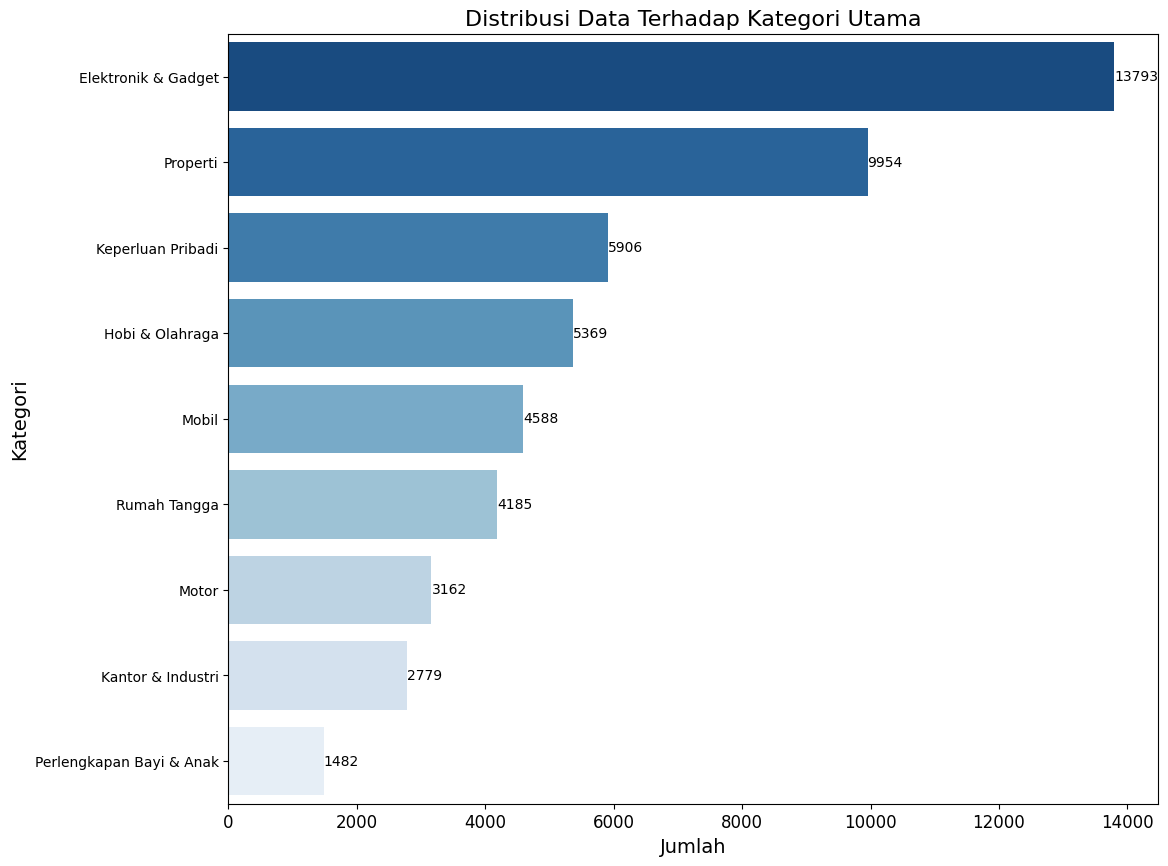

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

distribusi_kategori = df['Kategori'].value_counts()
palette = sns.color_palette("Blues", n_colors=len(distribusi_kategori))
palette.reverse()

plt.figure(figsize=(12, 10)) #seaborn
sns.barplot(x=distribusi_kategori.values, y=distribusi_kategori.index, palette=palette)

plt.title('Distribusi Data Terhadap Kategori Utama', fontsize=16)
plt.xlabel('Jumlah', fontsize=14)
plt.ylabel('Kategori', fontsize=14)

for index, value in enumerate(distribusi_kategori.values):
    plt.text(value, index, f'{value}', va='center', fontsize=10, color='black')

plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.show()


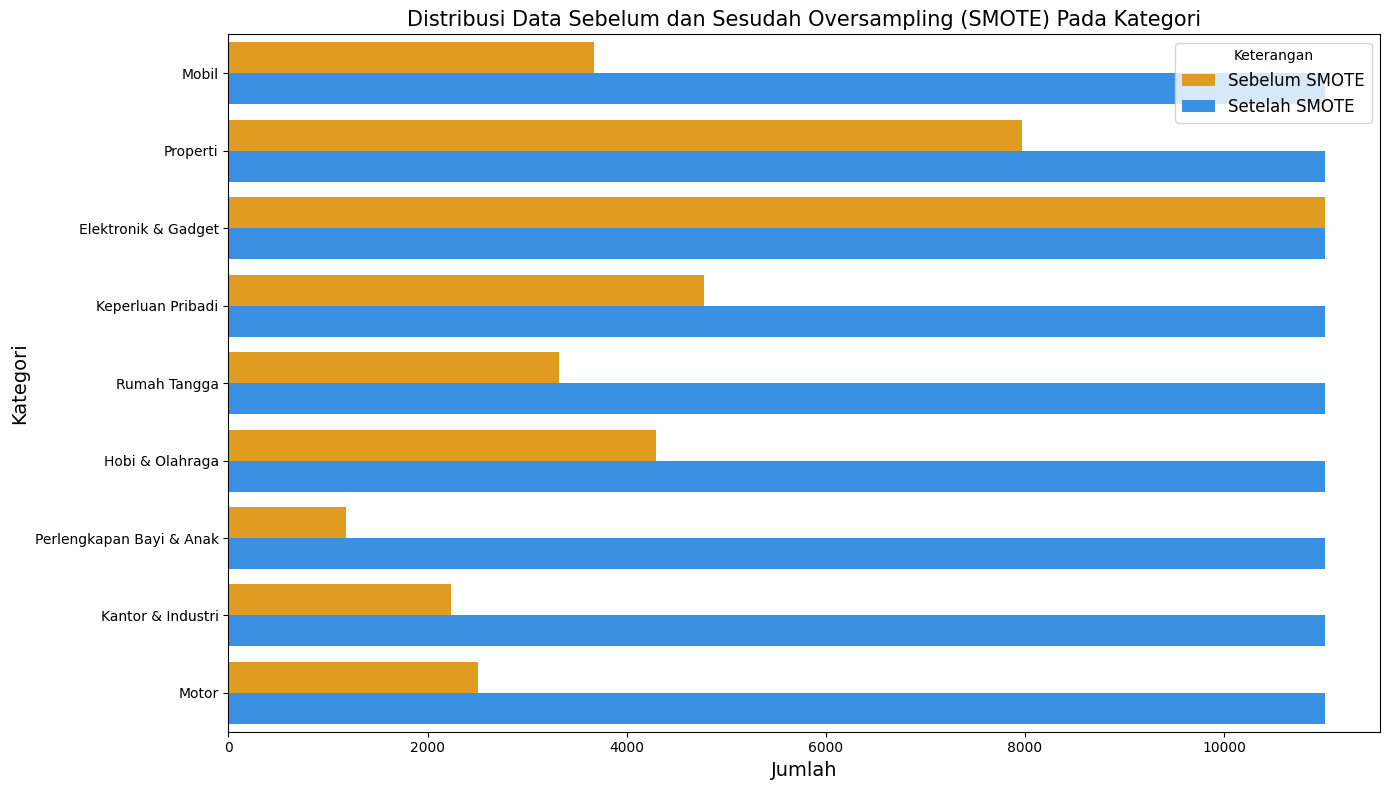

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['Nama Produk Final'])  # konversi teks
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['kategori_encoding'], test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

kategori_train = encoder.inverse_transform(y_train)
kategori_train_resampled = encoder.inverse_transform(y_train_resampled)

# Distribusi sebelum SMOTE
distribusi_sebelum_smote = Counter(kategori_train)

# Distribusi setelah SMOTE
distribusi_setelah_smote = Counter(kategori_train_resampled)

df_distribusi = pd.DataFrame({
    'Kategori': list(distribusi_sebelum_smote.keys()),
    'Sebelum SMOTE': list(distribusi_sebelum_smote.values()),
    'Setelah SMOTE': [distribusi_setelah_smote.get(kategori, 0) for kategori in distribusi_sebelum_smote.keys()]
})
df_distribusi_melted = df_distribusi.melt(id_vars="Kategori", var_name="Jenis", value_name="Jumlah")
plt.figure(figsize=(14, 8))

custom_palette = ["#FFA500", "#1E90FF"]  # Oranye (FFA500) dan Biru (1E90FF)

sns.barplot(x="Jumlah", y="Kategori", hue="Jenis", data=df_distribusi_melted, palette=custom_palette)
plt.title('Distribusi Data Sebelum dan Sesudah Oversampling (SMOTE) Pada Kategori', fontsize=15)
plt.xlabel('Jumlah', fontsize=14)
plt.ylabel('Kategori', fontsize=14)
plt.legend(title='Keterangan', fontsize=12)
plt.tight_layout()
plt.show()

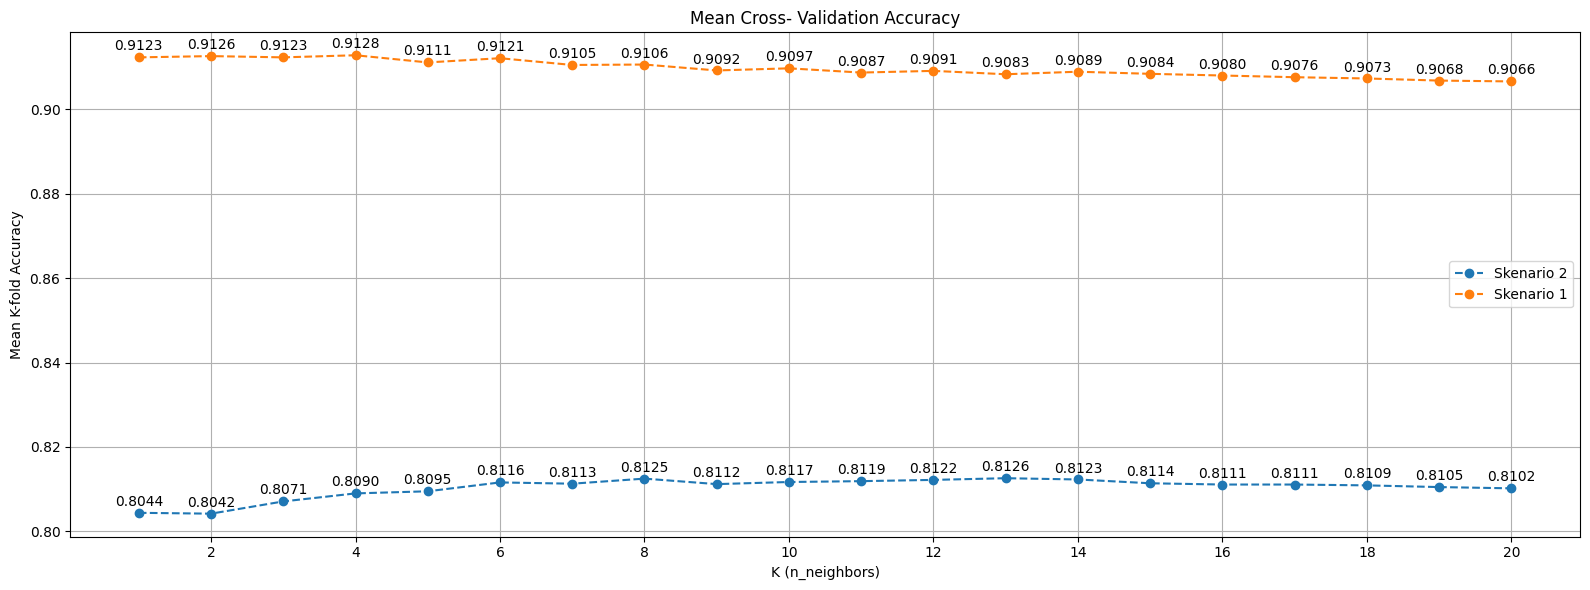

In [ ]:
import matplotlib.pyplot as plt

k_values = list(range(1, 21))
subkategori_accuracy = [
    0.8044, 0.8042, 0.8071, 0.8090, 0.8095, 0.8116, 0.8113, 0.8125, 0.8112, 0.8117,
    0.8119, 0.8122, 0.8126, 0.8123, 0.8114, 0.8111, 0.8111, 0.8109, 0.8105, 0.8102
]

kategori_accuracy = [
    0.9123, 0.9126, 0.9123, 0.9128, 0.9111, 0.9121, 0.9105, 0.9106, 0.9092, 0.9097,
    0.9087, 0.9091, 0.9083, 0.9089, 0.9084, 0.9080, 0.9076, 0.9073, 0.9068, 0.9066
]

plt.figure(figsize=(16, 6))

plt.plot(k_values, subkategori_accuracy, label='Skenario 2', marker='o', linestyle='--')
for i, txt in enumerate(subkategori_accuracy):
    plt.annotate(f'{txt:.4f}', (k_values[i], subkategori_accuracy[i]), textcoords="offset points", xytext=(0,5), ha='center')

# Plot for Kategori
plt.plot(k_values, kategori_accuracy, label='Skenario 1', marker='o', linestyle='--')
for i, txt in enumerate(kategori_accuracy):
    plt.annotate(f'{txt:.4f}', (k_values[i], kategori_accuracy[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.title('Mean Cross- Validation Accuracy')
plt.xlabel('K (n_neighbors)')
plt.ylabel('Mean K-fold Accuracy')
plt.legend()
plt.xticks([k for k in k_values if k % 2 == 0])

# add grid
plt.grid(True)
plt.tight_layout()
plt.show()